## Project 2: House Hunting for Families in King County

Name:Sam Lim

Course: Data Science Full Time

Date: 3/26/21 4:30 pm EST

Instructor: Claude Fried


In [1]:
# Your code here - remember to use markdown cells for comments as well!
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.datasets import make_regression
import sklearn.metrics as metrics
from random import gauss
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from statsmodels.stats import outliers_influence
import sklearn
sns.set_theme(color_codes=True)

In [165]:
print(sklearn.__version__)
# if version is not 0.24.1 go to home page -> new -> Terminal and type:
# conda update scikit-learn

0.24.1


## Business Problem

A realtorship is experiencing an influx of smaller families coming into King County as Microsoft has expanded and hired substantial amount of workers. It is your job to find a home for these families, and many also live alone. 

## Data Observation and Cleaning

### Data Keys
id - unique identified for a house <br>
price- Price is prediction target <br>
bedrooms- Number of Bedrooms/House <br>
bathrooms- Number of bathrooms/bedrooms <br>
sqft_living- Square footage of the home <br>
sqft_lot- Square footage of the lot <br>
floors- Total floors (levels) in house <br>
waterfront - House which has a view to a waterfront <br>
condition - How good the condition is ( Overall ) <br>
grade - overall grade given to the housing unit, based on King County grading system <br>
yr_built - Built Year

## Data Prep and Cleaning

First, unnecessary columns are dropped as well as some rows that contained incorrect data across the independent variables. The grade and condition columns are changed to type string so that it is seen as categorical data and not numerical.

In [3]:
kc_data=pd.read_csv('data/kc_house_data.csv')
kc_new=kc_data.drop(columns=['date','view','sqft_above','sqft_basement','yr_renovated','zipcode','lat','long','sqft_living15','sqft_lot15','waterfront'])
kc_new=kc_new.set_index('id')
kc_new.loc[kc_new['bedrooms']==33]=3 
#seemed to be an error because there were only 1.75 bathrooms and sqft_living was only 1620
kc_new=kc_new.drop(index=2402100895, axis=0)
#3 beds,baths,sqft_living, etc. everything was 3
kc_new['bldg_age']=2021-kc_new['yr_built']
kc_new['sqft_lot_only']=kc_new['sqft_lot']-(kc_new['sqft_living']/kc_new['floors']) #0 if (kc_new['floors']==1 && kc_new['sqft_living']==kc_new['sqft_lot']) else kc_new['sqft_lot']-(kc_new['sqft_living']/kc_new['floors'])
kc_new['grade']=kc_new['grade'].astype('str')         # grade and condition were type int, so needed to be changed
kc_new['condition']=kc_new['condition'].astype('str') # they are still categorized later

In [4]:
kc_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21596 entries, 7129300520 to 1523300157
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21596 non-null  float64
 1   bedrooms       21596 non-null  int64  
 2   bathrooms      21596 non-null  float64
 3   sqft_living    21596 non-null  int64  
 4   sqft_lot       21596 non-null  int64  
 5   floors         21596 non-null  float64
 6   condition      21596 non-null  object 
 7   grade          21596 non-null  object 
 8   yr_built       21596 non-null  int64  
 9   bldg_age       21596 non-null  int64  
 10  sqft_lot_only  21596 non-null  float64
dtypes: float64(4), int64(5), object(2)
memory usage: 2.0+ MB


### Logarithmic Scaling

In order to normalize the data, I created a new database that contained log-scaled values of the original the original data. Not all independent variables were logarithmically scaled, but the dependent variable, price was also log-scaled. This helped normalize the data.

In [175]:
logsqft_living=np.log(kc_new['sqft_living'])
logsqft_lot=np.log(kc_new['sqft_lot'])#_only'])
log_age=np.log(kc_new['bldg_age'])
log_price=np.log(kc_new['price'])

scaled_living=(logsqft_living-np.mean(logsqft_living))/np.sqrt(np.var(logsqft_living))
scaled_lot=(logsqft_lot-np.mean(logsqft_lot))/np.sqrt(np.var(logsqft_lot))
scaled_age=(log_age-np.mean(log_age))/np.sqrt(np.var(log_age))
kc_fin=pd.DataFrame([])

kc_fin['bedrooms']=kc_new['bedrooms']
kc_fin['bathrooms']=kc_new['bathrooms']
kc_fin['sqft_living']=scaled_living
kc_fin['sqft_lot']=scaled_lot
condition=kc_new['condition']
grade=(kc_new['grade'])


cond_dummies=pd.get_dummies(kc_new['condition'],prefix='cnd',drop_first=True)
grade_dummies=pd.get_dummies(kc_new['grade'],prefix='grade',drop_first=True)
price=kc_new['price']
kc_fin=pd.concat([log_price, kc_fin, cond_dummies],axis=1) # cond_dummies, grade_dummies],axis=1)
kc_fin=kc_fin.dropna() #drops 8 samples



## Data Modeling

Because the majority of the clients are small to mid-size families, houses with more than 5 bedrooms and houses with more than 4 bathrooms were dropped. This also helped with the linear regression model as the before-mentioned houses tended to be outliers

In [176]:
kc_fin2=kc_fin.drop(index=kc_fin.loc[kc_fin['bedrooms']>5].index.append(kc_fin.loc[kc_fin['bathrooms']>4].index))
kc_fin2.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,cnd_2,cnd_3,cnd_4,cnd_5
id,,,,,,,,,
7129300520,12.309982,3,1.00,-1.125577,-0.388446,0,1,0,0
6414100192,13.195614,3,2.25,0.709431,-0.113256,0,1,0,0
5631500400,12.100712,2,1.00,-2.131918,0.244461,0,1,0,0
2487200875,13.311329,4,3.00,0.070657,-0.523930,0,0,0,1
1954400510,13.142166,3,2.00,-0.292744,0.008125,0,1,0,0


In [174]:
kc_fin2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21061 entries, 7129300520 to 1523300157
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        21061 non-null  float64
 1   bedrooms     21061 non-null  int64  
 2   bathrooms    21061 non-null  float64
 3   sqft_living  21061 non-null  float64
 4   sqft_lot     21061 non-null  float64
 5   condition    21061 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 1.7+ MB


In [126]:
outcome = 'price'
predictors = kc_fin2.drop('price', axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum
print(formula)

price~bedrooms+bathrooms+sqft_living+sqft_lot+condition


In [127]:
model = ols(formula=formula, data=kc_fin2).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     2253.
Date:                Fri, 26 Mar 2021   Prob (F-statistic):               0.00
Time:                        14:16:44   Log-Likelihood:                -9178.8
No. Observations:               21061   AIC:                         1.838e+04
Df Residuals:                   21052   BIC:                         1.845e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         13.2128      0.073    181.587      0.000      13.070      13.355
condition[T.2]    -0.0868      0.076     -1.136      0.256      -0.237       0.063
condition[T.3]     0.0444      0.071      0.626      0.531      -0.095       0.183
condition[T.4]     0.1066      0.071      1.501      0.133      -0.033       0.246
condition[T.5]     0.2132      0.071      2.984      0.003       0.073       0.353
bedrooms          -0.0968      0.004    -23.666      0.000      -0.105      -0.089
bathrooms          0.0391      0.006      6.785      0.000       0.028       0.050
sqft_living        0.3929      0.005     81.695      0.000       0.384       0.402
sqft_lot          -0.0485      0.003    -16.956      0.000      -0.054      -0.043
==============================================================================
Omnibus:                       68.943   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.132
Skew:                           0.127   Prob(JB):                     1.60e-15
Kurtosis:                       2.887   Cond. No.                         259.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Multicollinearity Check

The model has some multicollinearity. First between the categorical variables and another between the number of bathrooms and the sqft_living, but that is to be expected. In this model, because the number of bathrooms as well as the sqft_living space is both important in determining the appropriate housing for the clients, neither variables will not be taken out.

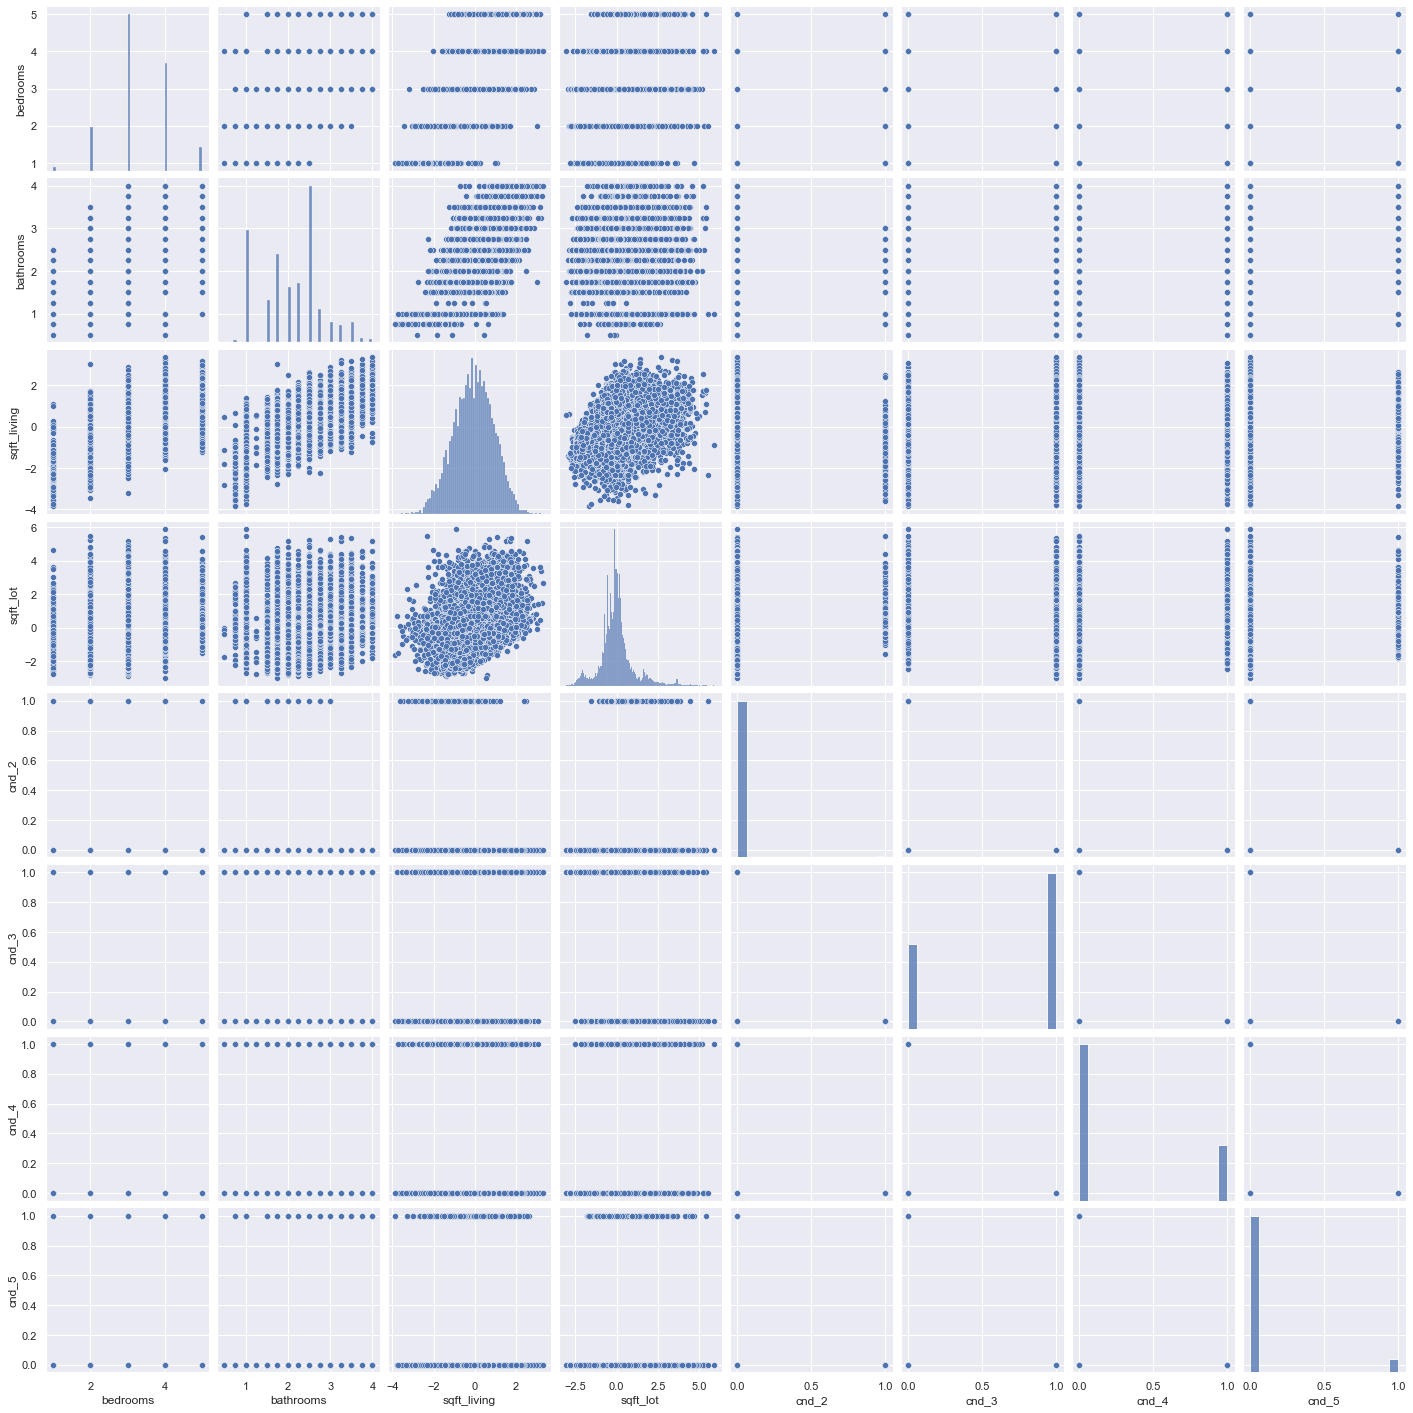

In [183]:
sns.pairplot(kc_fin2.drop('price',axis=1))

In [37]:
abs(predictors.corr()) >.75

,const,bedrooms,bathrooms,sqft_living,sqft_lot,cnd_2,cnd_3,cnd_4,cnd_5
const,False,False,False,False,False,False,False,False,False
bedrooms,False,True,False,False,False,False,False,False,False
bathrooms,False,False,True,False,False,False,False,False,False
sqft_living,False,False,False,True,False,False,False,False,False
sqft_lot,False,False,False,False,True,False,False,False,False
cnd_2,False,False,False,False,False,True,False,False,False
cnd_3,False,False,False,False,False,False,True,True,False
cnd_4,False,False,False,False,False,False,True,True,False
cnd_5,False,False,False,False,False,False,False,False,True


In [185]:
kc_pred=kc_fin2.drop(['price'],axis=1)
pred_df=kc_pred.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
pred_df['pairs'] = list(zip(pred_df.level_0, pred_df.level_1))

# set index to pairs
pred_df.set_index(['pairs'], inplace = True)

#d rop level columns
pred_df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
pred_df.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
pred_df.drop_duplicates(inplace=True)

In [186]:
pred_df[(pred_df.cc>.75) & (pred_df.cc <1)]

,cc
pairs,
"(cnd_3, cnd_4)",0.812203


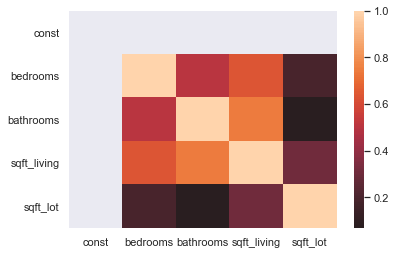

In [187]:
sns.heatmap(predictors.corr(), center=0);

# Linear Regression Assumptions

Proving that the assumptions regarding regression is met using the linear regression model above

## Linearity
The scatter plot of the independent variables to the dependent variables show that they have a linear relationship. The scatter plots also show that the data is homoscedastic, meeting two of the three assumptions.

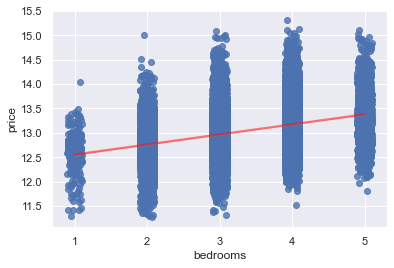

In [128]:
data=kc_fin2
ax_beds=sns.regplot(x='bedrooms',y='price',data=data,x_jitter=.1, line_kws={'color':'red','alpha':.5})

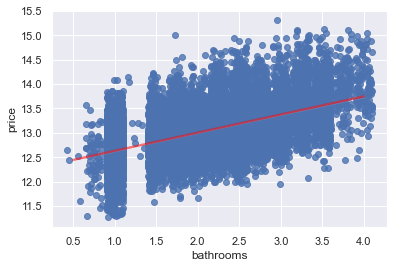

In [129]:
ax_baths=sns.regplot(x='bathrooms',y='price',data=data,x_jitter=.1, line_kws={'color':'red','alpha':.5})

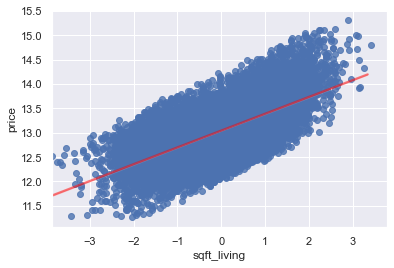

In [130]:
ax_living=sns.regplot(x='sqft_living',y='price',data=data,x_jitter=.1, line_kws={'color':'red','alpha':.5})

While we may assume heteroscedasticity for the sqft_lot, this is because there are many apartments meaning many of these houses have 0 sqft_lot. The price difference between apartments varies significantly depending on location, sqft of living space, commodities, and etc. If we overlook the top and bottom part of the scatter plot where sqft_lot is near 0, the rest of the plot is very linear.

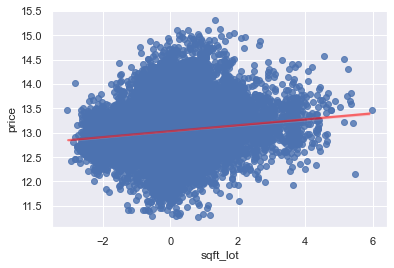

In [131]:
ax_lot=sns.regplot(x='sqft_lot',y='price',data=data,x_jitter=.1, line_kws={'color':'red','alpha':.5})

## Normality

### Q-Q Plot of the residuals

First by building a residuals data frame, I was able to create a Q-Q plot of the residuals using model.resid. The Q-Q plot shows that while it is not perfectly normally distributed, it is quite close.

In [16]:
residual_df=pd.DataFrame(sorted(model.resid), columns=['residual'])

In [79]:
residual_df['z_actual']=(residual_df['residual'].map 
                         (lambda x: (x-residual_df['residual'].mean())/residual_df['residual'].std()))
residual_df['rank']=residual_df.index+1
residual_df['percentile']=residual_df['rank'].map(lambda x: x/len(residual_df.residual))
residual_df['theo']=stats.norm.ppf(residual_df['percentile'])
residual_df['error']=residual_df['z_actual']-residual_df['theo']

residual_df.head()

,residual,z_actual,rank,percentile,theo,error
0,-1.165445,-3.117630,1,0.000047,-3.903024,0.785394
1,-1.124025,-3.006827,2,0.000095,-3.731959,0.725132
2,-1.121740,-3.000715,3,0.000142,-3.628570,0.627855
3,-1.104706,-2.955149,4,0.000190,-3.553602,0.598454
4,-1.101068,-2.945416,5,0.000237,-3.494477,0.549061


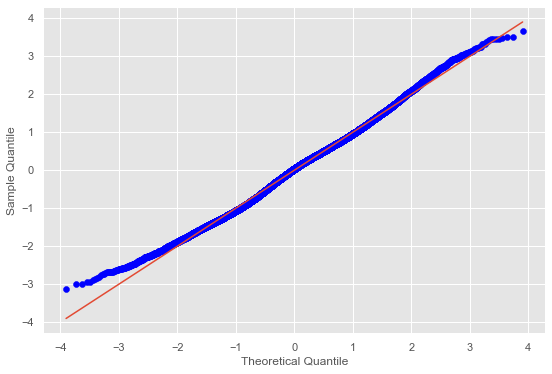

In [18]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(9,6))
    plt.scatter(residual_df['theo'],residual_df['z_actual'],color='blue')
    plt.xlabel('Theoretical Quantile')
    plt.ylabel('Sample Quantile')
    plt.plot(residual_df['theo'],residual_df['theo'])

### Histogram of Residuals 

Like the Q-Q plots, the histogram of the residuals also shows that the data is nearly normally distributed. 


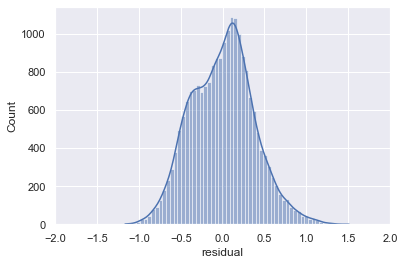

In [106]:
sns.histplot(residual_df['residual'],bins=60, kde=True, cbar=True)
plt.xlim((-2,2))
plt.show()

### Visualizing Error Terms

This section has a better visual representation of the linearity and homoscedasticity of the data. 

 - The Y and Fitted vs. X graph plots the dependent variable against our predicted values with a confidence interval. The positive relationship shows that independent varible and price are correlated, i.e., when one variable increases the other increases.

 - The Residuals versus height graph shows our model's errors versus the specified predictor variable. Each dot is an observed value; the line represents the mean of those observed values. If there's no pattern in the distance between the dots and the mean value, the OLS assumption of homoskedasticity holds.

 - The Partial regression plot shows the relationship between the independent variable and price, taking in to account the impact of adding other independent variables on our existing  coefficient. 

 - The Component and Component Plus Residual (CCPR) plot is an extension of the partial regression plot. It shows where the trend line would lie after adding the impact of adding our other independent variables on the price.

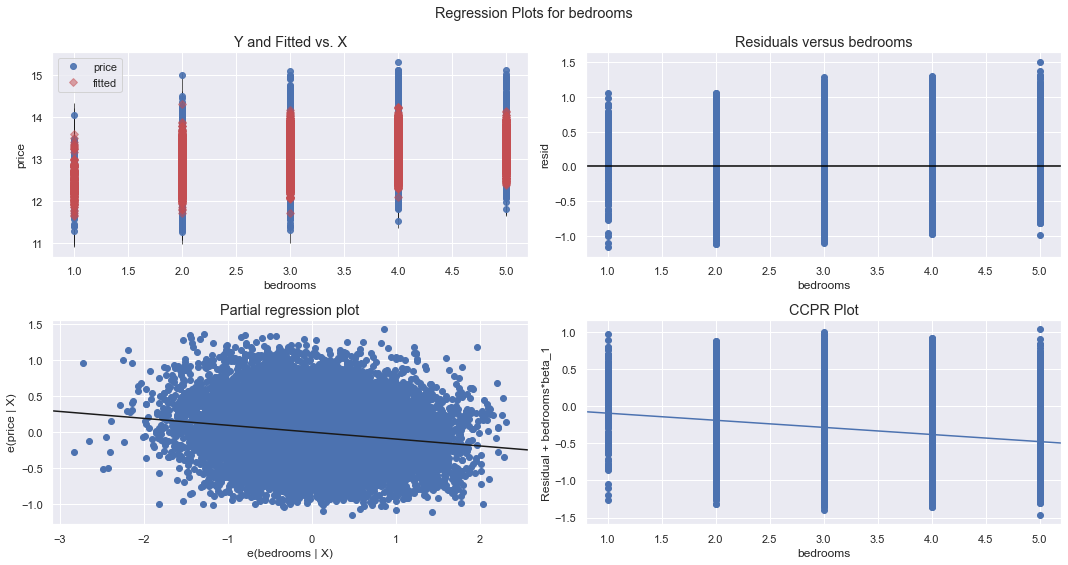

In [22]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "bedrooms", fig=fig)
plt.show()

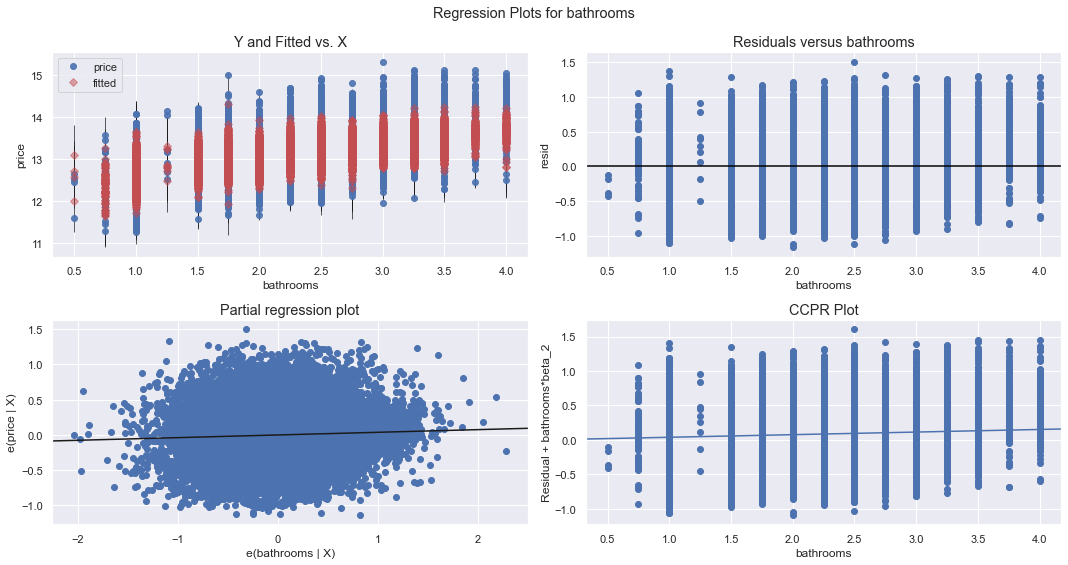

In [23]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "bathrooms", fig=fig)
plt.show()

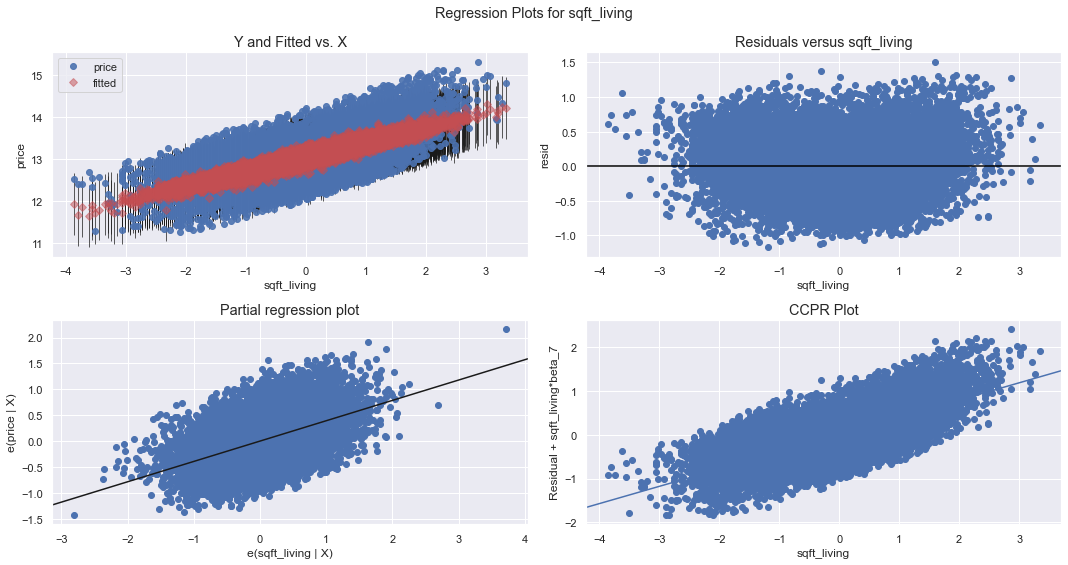

In [147]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "sqft_living", fig=fig)
plt.show()

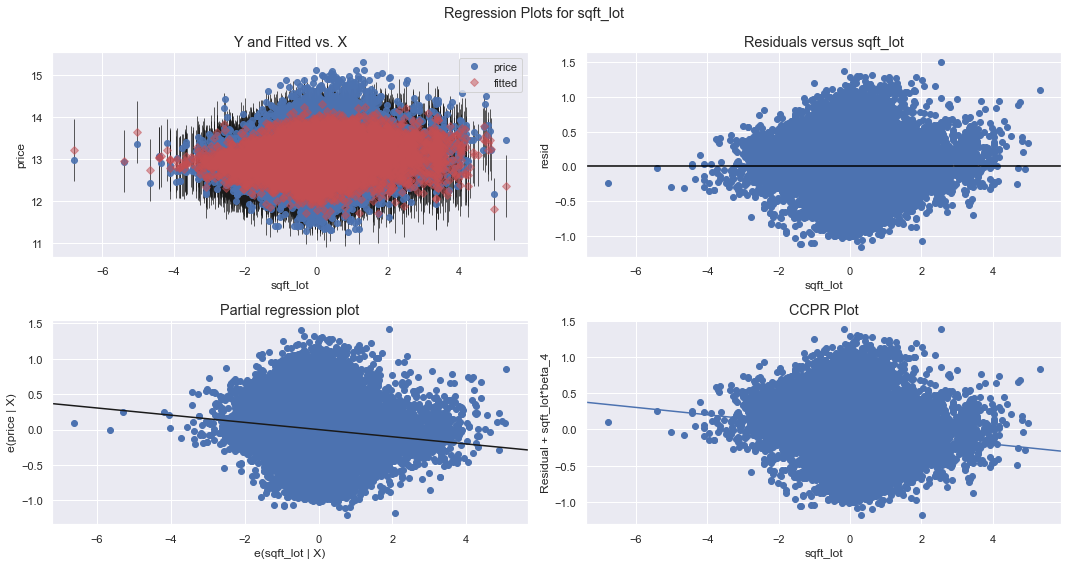

In [24]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "sqft_lot", fig=fig)
plt.show()

## Model Training

Creating test and train sets using 2:8 ratio. 

In [177]:
X_train, X_test, y_train, y_test = train_test_split(predictors,kc_fin2['price'], test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16848, 6), (4213, 6), (16848,), (4213,))

In [178]:
lr=LinearRegression()#positive=True)
predictors=sm.add_constant(predictors)
# y_train=np.array(y_train).reshape(-1,1)
lr.fit(X_train,y_train)
# predict_ls=fit_lr.predict(predictors)

yhat_train=lr.predict(X_train)
yhat_test=lr.predict(X_test)

In [179]:
np.array(X_train).shape#.reshape(-1,1).shape

(16848, 6)

In [180]:
train_residuals = yhat_train - y_train
test_residuals = yhat_test - y_test

In [181]:
mse_train = np.sum((y_train-yhat_train)**2)/len(y_train)
mse_test = np.sum((y_test-yhat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 0.13974070334839414
Test Mean Squarred Error: 0.14157959790555982


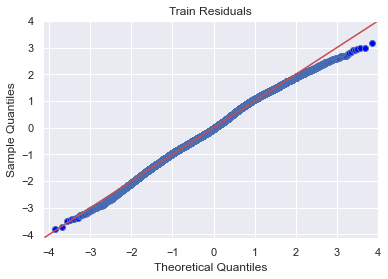

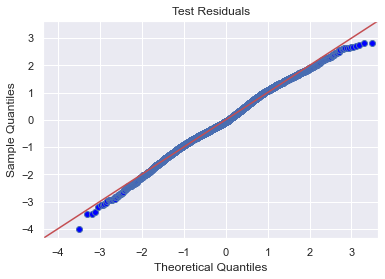

In [182]:
sm.graphics.qqplot(train_residuals,dist=stats.norm,line='45',fit=True)
plt.title('Train Residuals')
sm.graphics.qqplot(test_residuals,dist=stats.norm,line='45',fit=True)
plt.title('Test Residuals')
plt.show()

# Evaluation

While I was able to create a model that best represent the housing prices in King County based on the number of rooms and bathrooms, the size of the living space and lot space, and the overall condition of the house, it cannot be said that the model will be a wholsome representation of the actual population.

 - The number of bathrooms and the size of the living space increases the price of the house as expected; however, the number of bedrooms and the lot size decreased the price.
 
 - Because apartments/condos account for higher prices for houses with a lot size of 0, and thus explains the negative relationship. This may also explain the negative relationship between bedrooms and prices.
 
 - I believe that this model may be slightly inadequate to generalize beyond this data.

# Conclusion

The biggest challenges were first, trying to figure out why the relationship between lot size and number of bedrooms to the price were negative, and much effort was put into trying to make the coefficients be positive in the model. Also, not having any information on the neighborhoods depending on the zipcode would have given better insight to my clients as it is an important factor for them. 


 - Being able to differentiate between the type of housing through the use of zipcode will be highly beneficial.
 
 - In the future, understanding that it is okay for coefficients to be negative even if it goes personal intuition is okay.